# An Initial Exploration of LIV + UV KASH cells image analysis

## Data Loading and Preprocessing

In [809]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from itertools import combinations
from statannotations.Annotator import Annotator

In [810]:
file_path = r"D:\BioLab\Current_experiments\Anamaria_3d_experiment\02.08.2023_analysis_data\cell_stat.csv"
initial_df = pd.read_csv(file_path)
initial_df = initial_df.dropna(how='all')
initial_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,0.0,806.897504,16.754965,22.028102,4.83,6729.655903,False,0.541947,201.577605,False,0.729065,1132.377725,False,0.585434
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,1.0,952.236665,20.156989,23.814164,4.83,8577.352984,False,0.418536,272.515293,False,0.670605,1061.525241,False,0.476332
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,0.0,2.0,876.020431,23.644063,23.388911,4.14,6156.514872,False,0.429753,276.640986,False,0.789751,798.830812,False,0.498207
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,0.0,562.743684,23.729113,14.798802,3.68,6000.349685,False,0.509300,174.732833,False,0.770712,1002.777966,False,0.460356
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,1.0,1.0,653.607384,21.517798,17.180218,3.91,5991.107759,False,0.608029,220.098386,False,0.984069,983.538912,False,0.425511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,6.0,625.024528,15.479207,16.584864,4.83,11348.826460,False,0.373554,278.427674,True,1.257069,389.666562,True,1.601489
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,7.0,447.677726,16.329712,22.113152,3.45,5298.617721,False,0.444044,318.479040,False,1.014304,362.848877,True,1.215143
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,8.0,401.402782,13.523043,24.494569,2.99,5613.789133,False,0.408044,586.012119,False,0.892378,388.281632,False,1.042119
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,151.0,9.0,564.869929,18.881230,18.115775,3.68,9883.328956,False,0.337443,181.074825,False,0.834287,371.442420,True,1.621345


In [811]:
def extract_info(image_name):
    date_pattern = re.compile(r'\d+-\d+-\d+')
    date = date_pattern.search(image_name).group(0)

    doxy = "+doxy" if "+doxy" in image_name else "-doxy"

    liv = "+LIV" if "+LIV" in image_name else "-LIV"

    treatment = "+Cisp" if "+Cisp" in image_name else "Control"

    time_pattern = re.compile(r'0hr|24hr|48hr')
    time = time_pattern.search(image_name).group(0)

    return pd.Series([date, doxy, liv, treatment, time], index=['Date', 'Doxy', 'LIV', 'Treatment', 'Time'])



In [812]:
# Extract the information into temporary DataFrame
temp_df = initial_df['Image_name'].apply(extract_info)

# Find the index of the "Image_name" column
idx = initial_df.columns.get_loc('Image_name') + 1

# Insert the new columns
for col in reversed(temp_df.columns):
    initial_df.insert(loc=idx, column=col, value=temp_df[col])


In [813]:
initial_df

,Image_name,Date,Doxy,LIV,Treatment,Time,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre",...,"Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,0.0,806.897504,16.754965,...,4.83,6729.655903,False,0.541947,201.577605,False,0.729065,1132.377725,False,0.585434
3,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,1.0,952.236665,20.156989,...,4.83,8577.352984,False,0.418536,272.515293,False,0.670605,1061.525241,False,0.476332
5,23-6-9 Kash +Cisp +LIV 0hr-01.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,0.0,2.0,876.020431,23.644063,...,4.14,6156.514872,False,0.429753,276.640986,False,0.789751,798.830812,False,0.498207
7,23-6-9 Kash +Cisp +LIV 0hr-02.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,1.0,0.0,562.743684,23.729113,...,3.68,6000.349685,False,0.509300,174.732833,False,0.770712,1002.777966,False,0.460356
9,23-6-9 Kash +Cisp +LIV 0hr-02.czi,23-6-9,-doxy,+LIV,+Cisp,0hr,1.0,1.0,653.607384,21.517798,...,3.91,5991.107759,False,0.608029,220.098386,False,0.984069,983.538912,False,0.425511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,6.0,625.024528,15.479207,...,4.83,11348.826460,False,0.373554,278.427674,True,1.257069,389.666562,True,1.601489
1497,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,7.0,447.677726,16.329712,...,3.45,5298.617721,False,0.444044,318.479040,False,1.014304,362.848877,True,1.215143
1499,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,8.0,401.402782,13.523043,...,2.99,5613.789133,False,0.408044,586.012119,False,0.892378,388.281632,False,1.042119
1501,23-6-9 Kash+doxy Control -LIV 48hr-10.czi,23-6-9,+doxy,-LIV,Control,48hr,151.0,9.0,564.869929,18.881230,...,3.68,9883.328956,False,0.337443,181.074825,False,0.834287,371.442420,True,1.621345


In [814]:
initial_df.columns

Index(['Image_name', 'Date', 'Doxy', 'LIV', 'Treatment', 'Time', 'Img_num',
       'Cell_num', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'Cy5-T1 av_signal_in_nuc_area_3D',
       'Cy5-T1 has ring', 'Cy5-T1 ring intensity coef',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'AF488-T3 has ring', 'AF488-T3 ring intensity coef'],
      dtype='object')

In [815]:
filtered_df = initial_df[['Doxy', 'LIV', 'Treatment', 'Time', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D']]

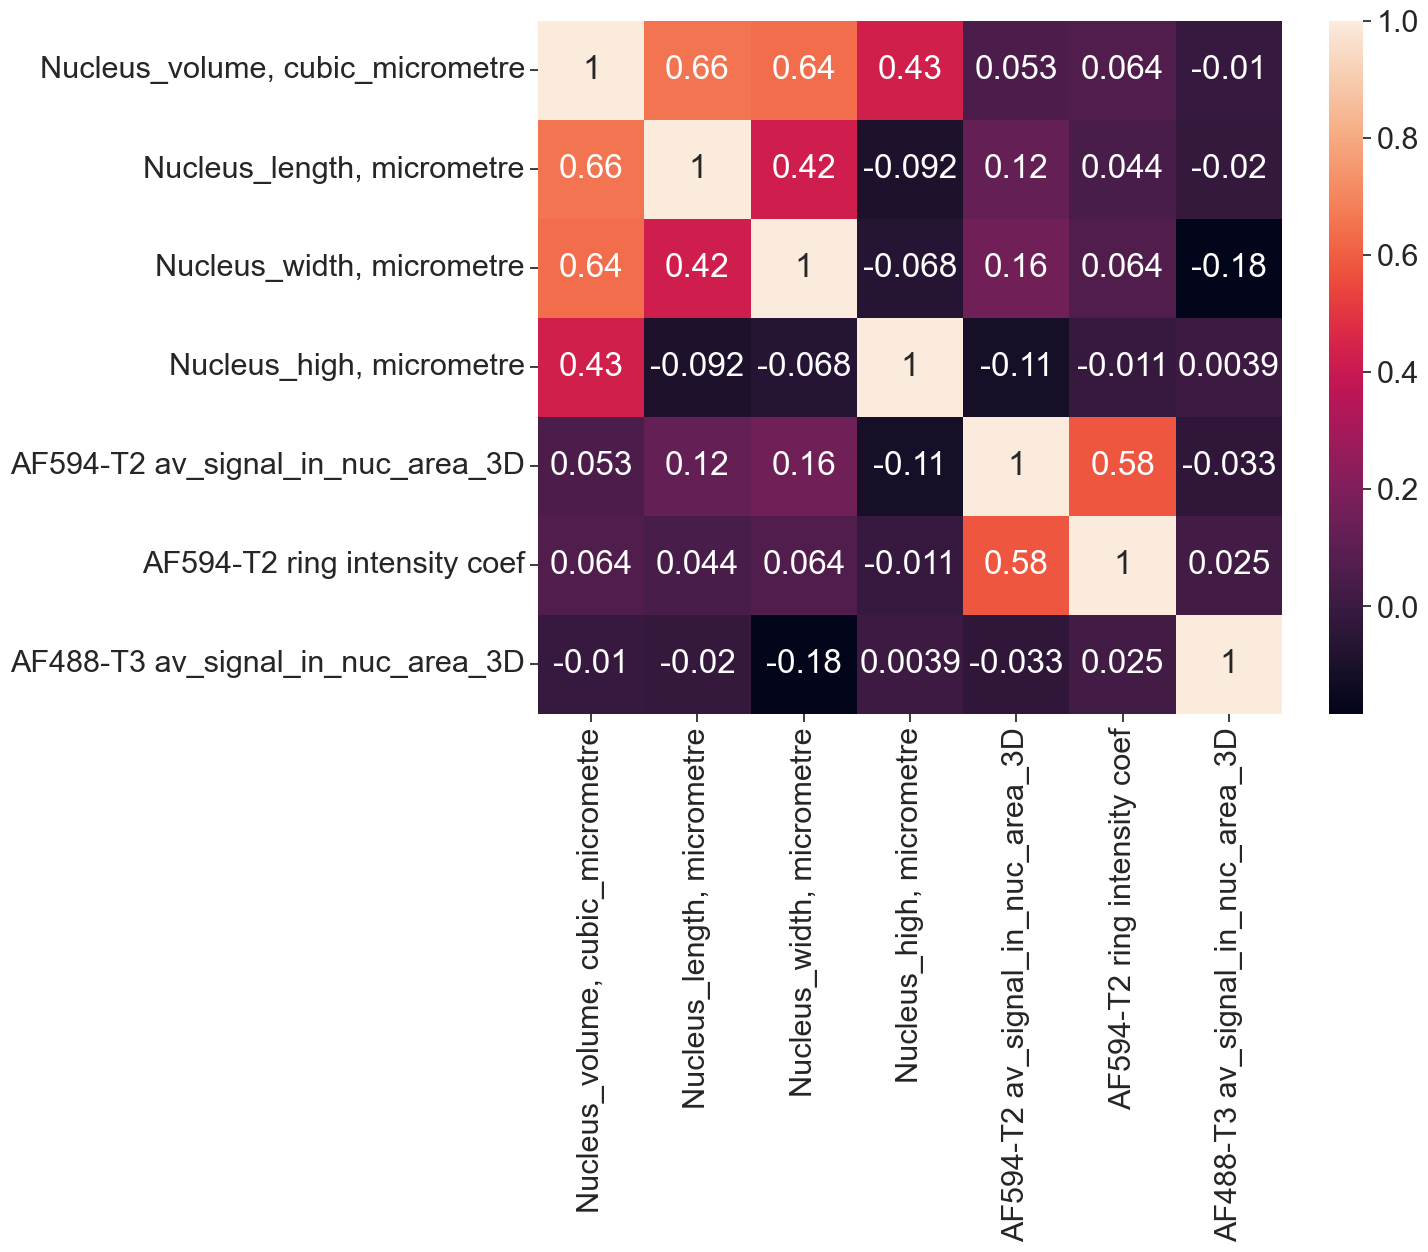

In [816]:
correlation_matrix = filtered_df.corr()
plt.figure(figsize=(12, 9)) # Set the size to 15 inches wide and 10 inches tall
sns.heatmap(correlation_matrix, annot=True)
plt.show()

C:\Users\nnina\AppData\Local\Temp\ipykernel_36504\2698417977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']


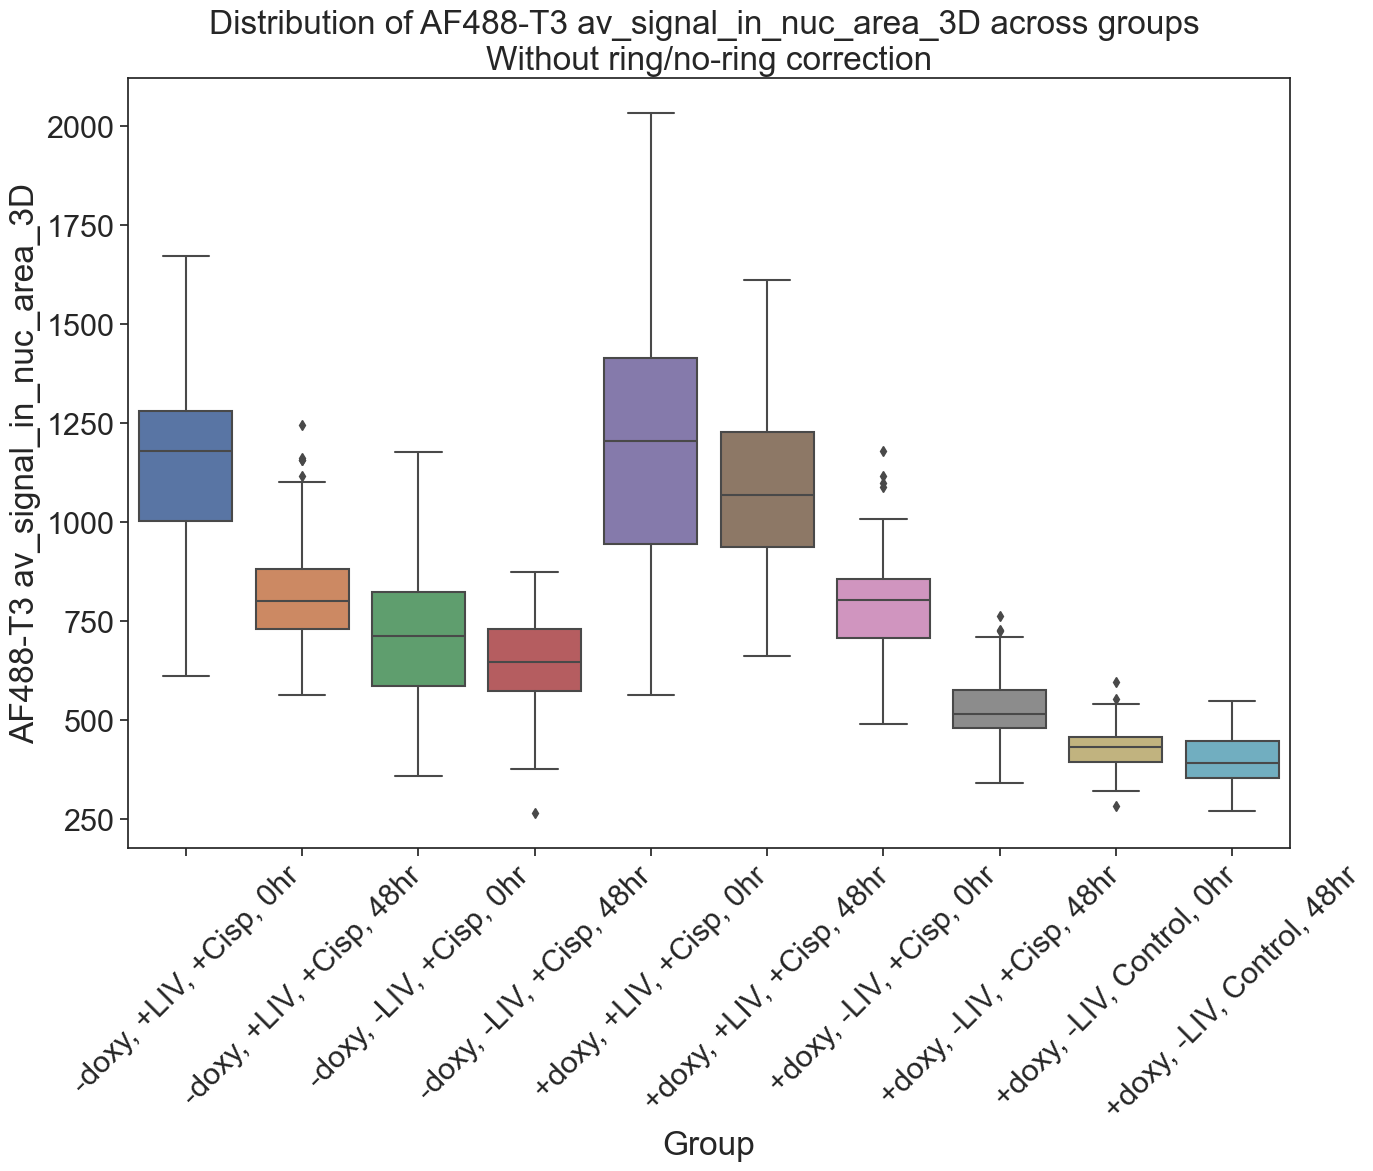

In [817]:
filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']
plt.figure(figsize=(15, 10))
sns.boxplot(x='Group', y='AF488-T3 av_signal_in_nuc_area_3D', data=filtered_df)
plt.title('Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups \nWithout ring/no-ring correction')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.savefig('figures/Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups.png', dpi=300, bbox_inches='tight')
plt.show()

## Signal background

Acquire control cells and measure the average signal at 0h and 48 hours for all cells. This signal will then be subtracted from the average signal of each cell subsequently.

In [818]:
cnt_signal = filtered_df[filtered_df['Treatment'] == 'Control']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
cnt_signal

410.5263591651428

In [819]:
filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] - cnt_signal
a = filtered_df[filtered_df['Treatment'] == '+Cisp']
a[a['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] < 0]

C:\Users\nnina\AppData\Local\Temp\ipykernel_36504\203686072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] - cnt_signal


,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background
351,-doxy,-LIV,+Cisp,0hr,617.031977,21.432748,22.453355,3.91,97.301324,False,0.822792,359.804290,"-doxy, -LIV, +Cisp, 0hr",-50.722069
363,-doxy,-LIV,+Cisp,0hr,604.193816,21.858001,23.473962,3.68,105.551998,False,0.830428,376.128042,"-doxy, -LIV, +Cisp, 0hr",-34.398317
461,-doxy,-LIV,+Cisp,48hr,828.219016,26.620833,23.814164,2.99,129.882317,False,0.826849,377.031733,"-doxy, -LIV, +Cisp, 48hr",-33.494626
473,-doxy,-LIV,+Cisp,48hr,627.578351,16.329712,14.798802,6.44,115.451123,False,0.620924,265.948572,"-doxy, -LIV, +Cisp, 48hr",-144.577788
477,-doxy,-LIV,+Cisp,48hr,938.259682,23.388911,18.115775,5.52,125.406467,False,0.866650,388.667661,"-doxy, -LIV, +Cisp, 48hr",-21.858698
1017,+doxy,-LIV,+Cisp,48hr,896.373654,22.538405,23.729113,4.60,413.803354,True,1.377927,369.403769,"+doxy, -LIV, +Cisp, 48hr",-41.122590
1047,+doxy,-LIV,+Cisp,48hr,1005.968441,30.278009,32.489324,3.45,92.953357,False,0.892662,341.740718,"+doxy, -LIV, +Cisp, 48hr",-68.785641
1055,+doxy,-LIV,+Cisp,48hr,493.253904,19.391534,26.620833,4.14,184.761776,False,0.810215,347.825809,"+doxy, -LIV, +Cisp, 48hr",-62.700550
1071,+doxy,-LIV,+Cisp,48hr,437.950737,22.113152,19.136382,3.68,184.385372,True,1.138305,347.619353,"+doxy, -LIV, +Cisp, 48hr",-62.907006
1085,+doxy,-LIV,+Cisp,48hr,490.019616,22.028102,24.579619,2.99,444.716542,False,0.853185,393.251679,"+doxy, -LIV, +Cisp, 48hr",-17.274680


## Total repair signal within nucleus area

New column titled "AF488-T3 Volume_corrected_signal_in_nuc_area_3D." This will display the repair signal within each nucleus in its entirety. The value is derived from the background-corrected average signal.

In [820]:
resolution = 0.085 * 0.058 * 0.230 #x.resolution * y.resolution * z.resolution
filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] * filtered_df['Nucleus_volume, cubic_micrometre']

C:\Users\nnina\AppData\Local\Temp\ipykernel_36504\1296815621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D_removed_background'] * filtered_df['Nucleus_volume, cubic_micrometre']


In [851]:
import csv
RING_CUTT_OFF_COEF = 1
filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF

with pd.ExcelWriter('raw_data.xlsx') as writer:
    filtered_df.to_excel(writer, index=False)


filtered_df.to_csv('raw_data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

C:\Users\nnina\AppData\Local\Temp\ipykernel_36504\1811541625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF


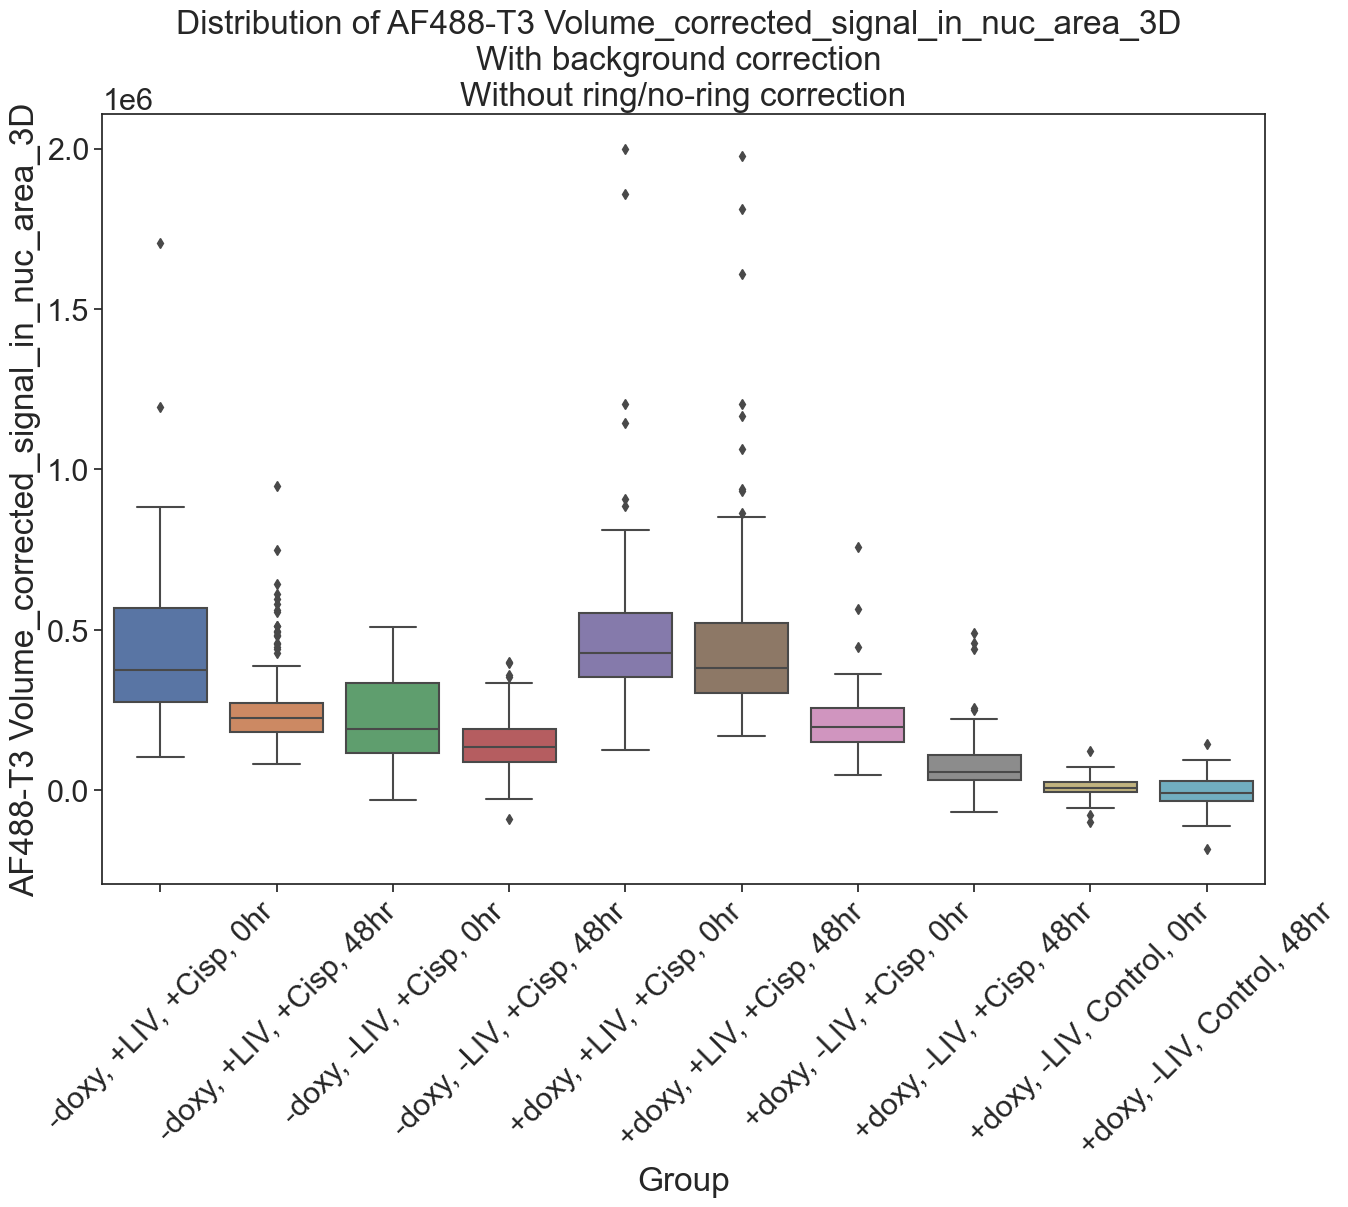

In [822]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Group', y='AF488-T3 Volume_corrected_signal_in_nuc_area_3D', data=filtered_df)
plt.title('Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D \nWith background correction \nWithout ring/no-ring correction')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.savefig('figures/Distribution of AF488-T3 Volume_corrected_signal_in_nuc_area_3D.png', dpi=300, bbox_inches='tight')
plt.show()

## -Doxy + Cisp +LIV/-LIV 0hr/48hr

In [823]:
minus_doxy_plus_cisp_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp')]
minus_doxy_plus_cisp_df

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1,-doxy,+LIV,+Cisp,0hr,806.897504,16.754965,22.028102,4.83,201.577605,False,0.729065,1132.377725,"-doxy, +LIV, +Cisp, 0hr",721.851366,582460.065135
3,-doxy,+LIV,+Cisp,0hr,952.236665,20.156989,23.814164,4.83,272.515293,False,0.670605,1061.525241,"-doxy, +LIV, +Cisp, 0hr",650.998882,619905.004352
5,-doxy,+LIV,+Cisp,0hr,876.020431,23.644063,23.388911,4.14,276.640986,False,0.789751,798.830812,"-doxy, +LIV, +Cisp, 0hr",388.304453,340162.634073
7,-doxy,+LIV,+Cisp,0hr,562.743684,23.729113,14.798802,3.68,174.732833,False,0.770712,1002.777966,"-doxy, +LIV, +Cisp, 0hr",592.251607,333285.851085
9,-doxy,+LIV,+Cisp,0hr,653.607384,21.517798,17.180218,3.91,220.098386,False,0.984069,983.538912,"-doxy, +LIV, +Cisp, 0hr",573.012553,374525.235559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-doxy,-LIV,+Cisp,48hr,932.438296,20.156989,19.136382,4.60,143.661816,False,0.944387,614.407375,"-doxy, -LIV, +Cisp, 48hr",203.881016,190106.467426
617,-doxy,-LIV,+Cisp,48hr,344.116450,17.350319,17.350319,3.22,151.938173,False,0.906911,756.248506,"-doxy, -LIV, +Cisp, 48hr",345.722147,118968.678166
619,-doxy,-LIV,+Cisp,48hr,370.614654,16.329712,22.793557,3.68,115.776041,True,1.012131,524.895621,"-doxy, -LIV, +Cisp, 48hr",114.369261,42386.924278
621,-doxy,-LIV,+Cisp,48hr,382.713288,16.329712,16.159611,3.68,141.560051,False,0.911091,729.461416,"-doxy, -LIV, +Cisp, 48hr",318.935057,122060.684049


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

-LIV_0hr vs. -LIV_48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.757e-03 U_stat=3.532e+03
+LIV_0hr vs. +LIV_48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.643e-10 U_stat=4.699e+03


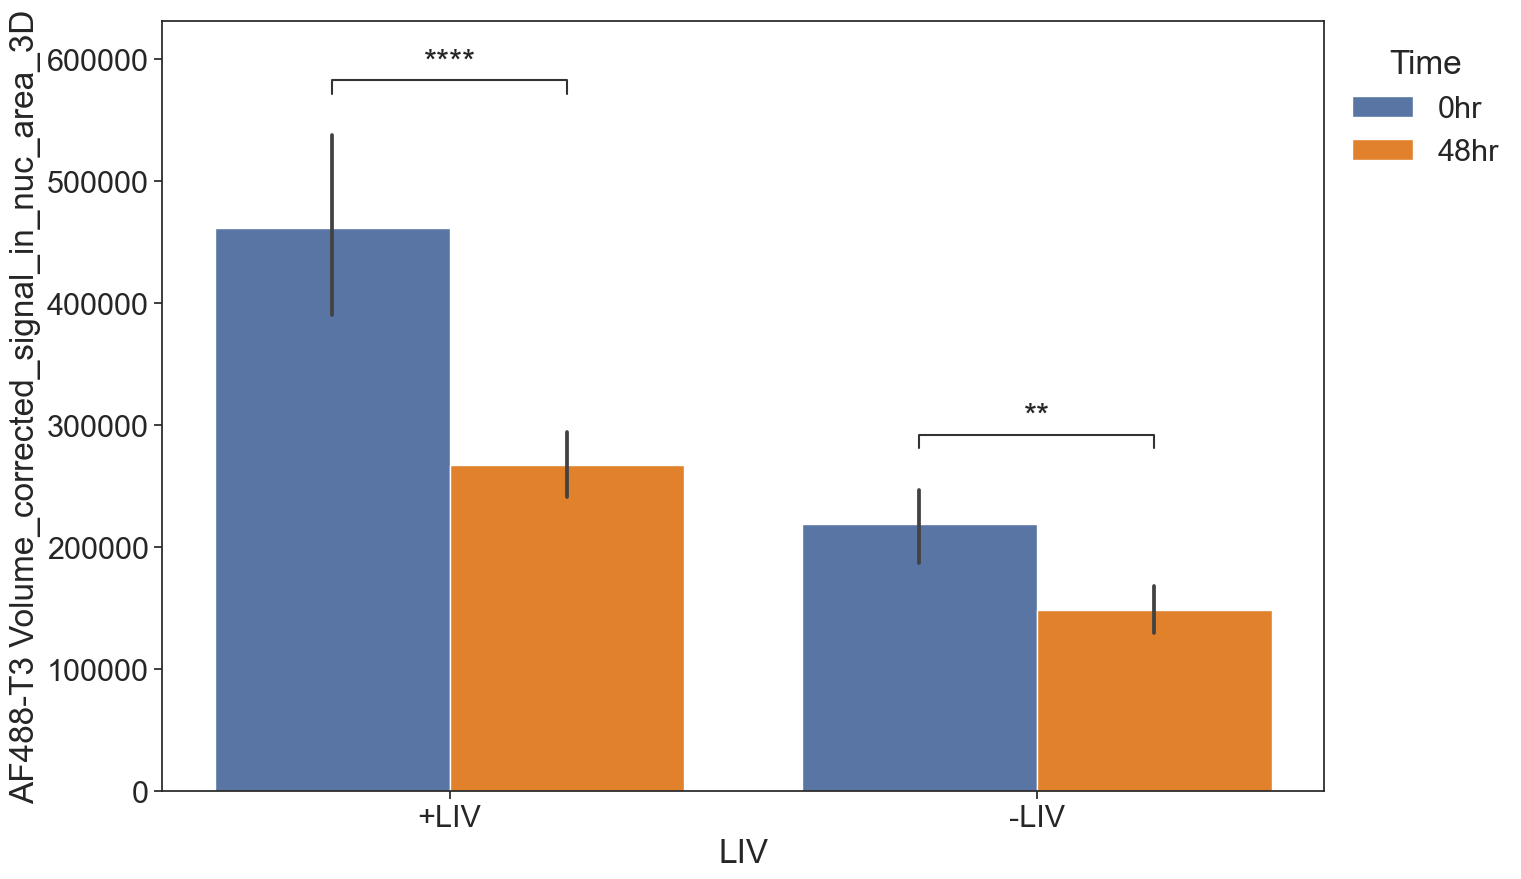

In [824]:
# Custom colors
blue = (0.298, 0.447, 0.690)  # a desaturated blue color
orange = (1.0, 0.498, 0.055)  # a desaturated orange color
pal = [blue, orange]

sns.set(font_scale=2, rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)}, style="ticks")

significanceComparisons = [(('+LIV', '0hr'), ('+LIV', '48hr')),
                           (('-LIV', '0hr'), ('-LIV','48hr'))]

fig_args = {'x': 'LIV',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'hue':'Time',
            'data': minus_doxy_plus_cisp_df,
            'dodge': True,
            'palette': pal}

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

fig, ax = plt.subplots(1,1, figsize=(15,10))

sns.barplot(ax=ax, **fig_args)
annotator = Annotator(ax=ax, pairs=significanceComparisons,
                      **fig_args)
annotator.configure(**configuration).apply_test().annotate()


# Move legend and remove its background
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
legend = ax.legend_
legend.get_frame().set_alpha(0)

In [825]:
filtered_df

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1,-doxy,+LIV,+Cisp,0hr,806.897504,16.754965,22.028102,4.83,201.577605,False,0.729065,1132.377725,"-doxy, +LIV, +Cisp, 0hr",721.851366,582460.065135
3,-doxy,+LIV,+Cisp,0hr,952.236665,20.156989,23.814164,4.83,272.515293,False,0.670605,1061.525241,"-doxy, +LIV, +Cisp, 0hr",650.998882,619905.004352
5,-doxy,+LIV,+Cisp,0hr,876.020431,23.644063,23.388911,4.14,276.640986,False,0.789751,798.830812,"-doxy, +LIV, +Cisp, 0hr",388.304453,340162.634073
7,-doxy,+LIV,+Cisp,0hr,562.743684,23.729113,14.798802,3.68,174.732833,False,0.770712,1002.777966,"-doxy, +LIV, +Cisp, 0hr",592.251607,333285.851085
9,-doxy,+LIV,+Cisp,0hr,653.607384,21.517798,17.180218,3.91,220.098386,False,0.984069,983.538912,"-doxy, +LIV, +Cisp, 0hr",573.012553,374525.235559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,+doxy,-LIV,Control,48hr,625.024528,15.479207,16.584864,4.83,278.427674,True,1.257069,389.666562,"+doxy, -LIV, Control, 48hr",-20.859797,-13037.884569
1497,+doxy,-LIV,Control,48hr,447.677726,16.329712,22.113152,3.45,318.479040,True,1.014304,362.848877,"+doxy, -LIV, Control, 48hr",-47.677482,-21344.146663
1499,+doxy,-LIV,Control,48hr,401.402782,13.523043,24.494569,2.99,586.012119,False,0.892378,388.281632,"+doxy, -LIV, Control, 48hr",-22.244727,-8929.095282
1501,+doxy,-LIV,Control,48hr,564.869929,18.881230,18.115775,3.68,181.074825,False,0.834287,371.442420,"+doxy, -LIV, Control, 48hr",-39.083939,-22077.341998


## -Doxy +LIV +Cisp


In [826]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
minus_doxy_plus_cisp_plus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

minus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total -Doxy +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_df)}")
print(f"No ring -Doxy +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df)} = "
      f"0hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr'])}")

Total -Doxy +LIV +Cisp: 163
No ring -Doxy +LIV +Cisp: 162 = 0hr: 53 + 48hr: 109


In [827]:
# Extract data for '0hr' and '48hr' groups
group_0hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

group_48hr_minus_doxy_plus_liv_plus_cisp = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)


p-value: 3.479893171861783e-10


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.480e-10 U_stat=4.647e+03


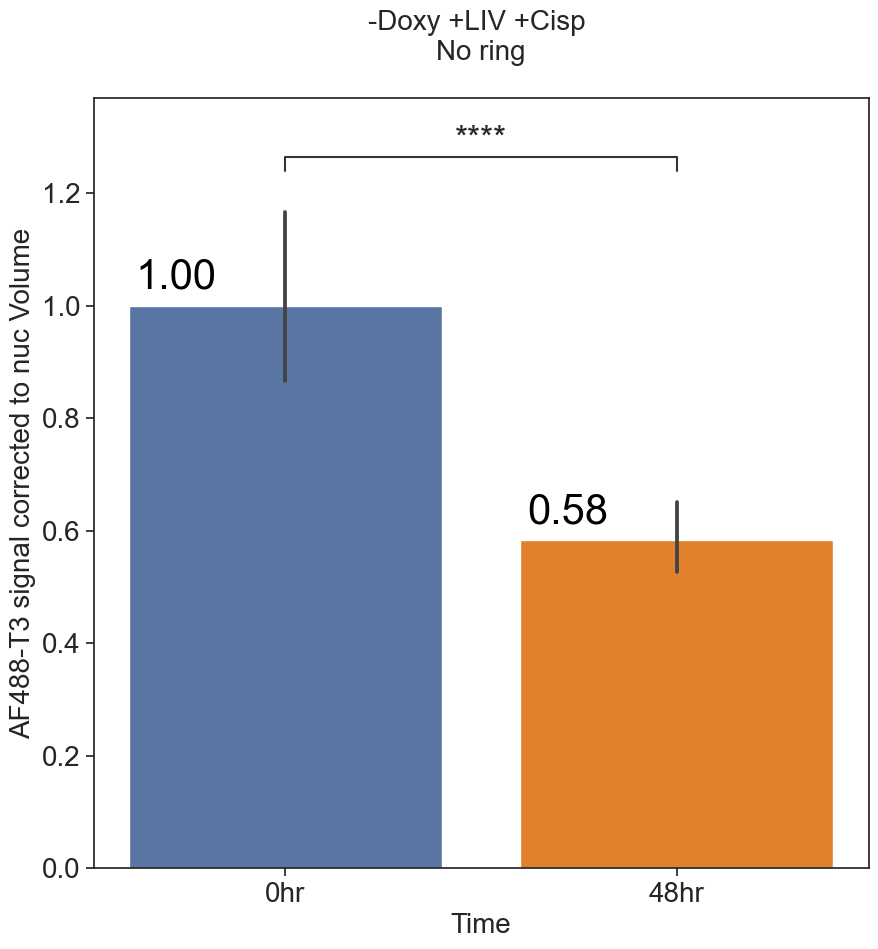

In [828]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]

fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

## +Doxy +LIV +Cisp

In [829]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
plus_doxy_plus_cisp_plus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()

plus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_plus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_df)}")

print(f"With ring +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df)} = "
      f"0hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '48hr'])}")

Total +Doxy +LIV +Cisp: 150
With ring +Doxy +LIV +Cisp: 97 = 0hr: 41 + 48hr: 56


In [830]:
# Extract data for '0hr' and '48hr' groups
group_0hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)

p-value: 0.19238483612119361


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.924e-01 U_stat=1.327e+03


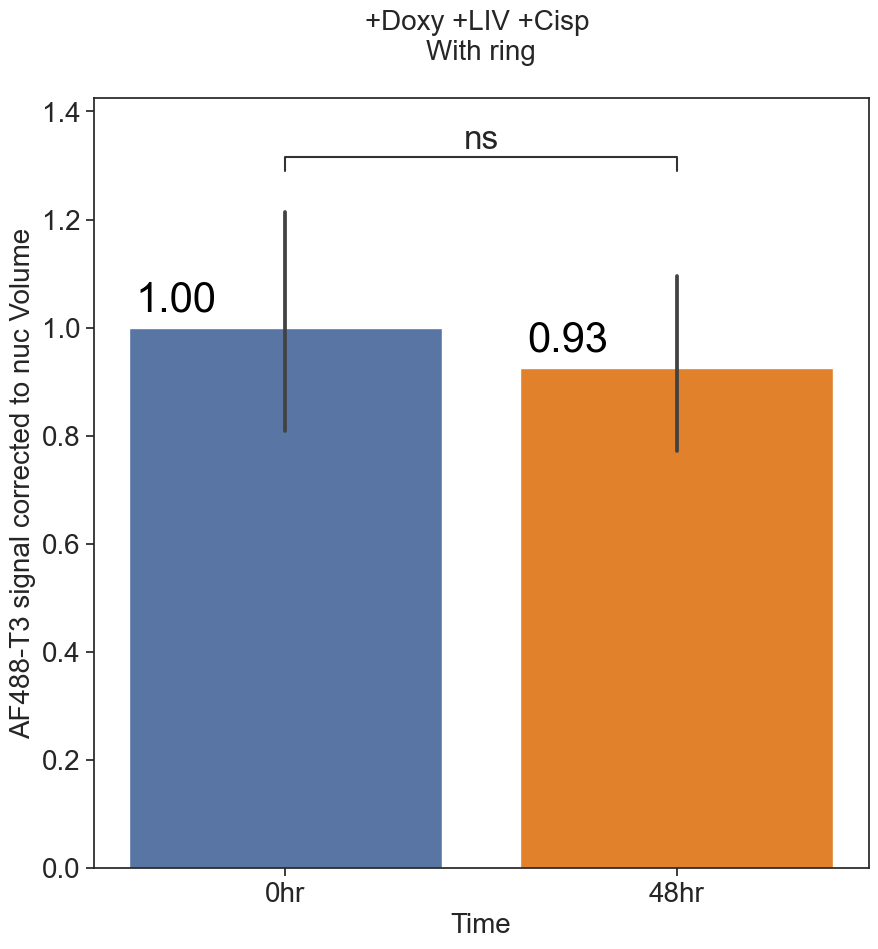

In [831]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/+Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

## -Doxy -LIV +Cisp

In [832]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
minus_doxy_plus_cisp_minus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

minus_doxy_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_minus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr
print(f"Total -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_minus_liv_df)}")
print(f"No ring -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df)} = "
      f"0hr: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '48hr'])}")

Total -Doxy -LIV +Cisp: 149
No ring -Doxy -LIV +Cisp: 141 = 0hr: 64 + 48hr: 77


In [833]:
# Extract data for '0hr' and '48hr' groups
group_0hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = minus_doxy_plus_cisp_minus_liv_no_ring_df[minus_doxy_plus_cisp_minus_liv_no_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

print(f"P-value for volume: {p}")

P-value for volume: 0.00377147857902469


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.771e-03 U_stat=3.164e+03


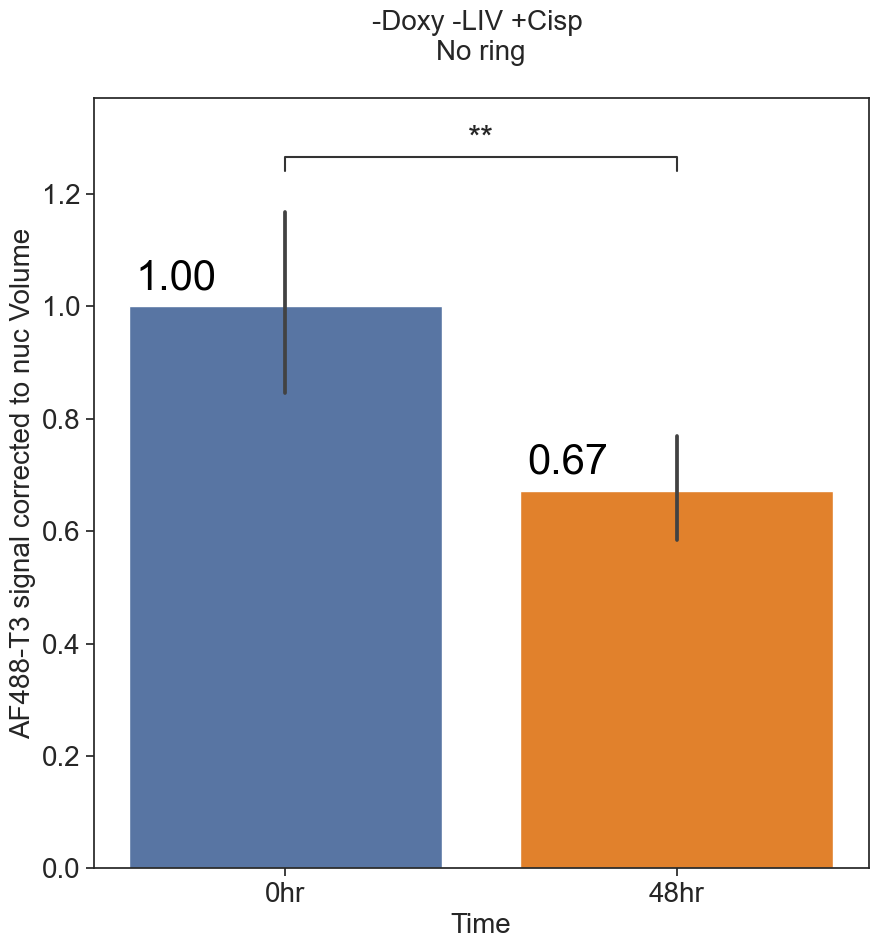

In [834]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')

## +Doxy -LIV +Cisp

In [835]:
# Filter DataFrame to only include '+Doxy +Crisp -LIV' group with rings
plus_doxy_plus_cisp_minus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()


plus_doxy_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()

plus_doxy_plus_cisp_minus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr


print(f"Total +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_df)}")
print(f"With ring +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df)} = "
      f"0hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr'])} + "
      f"48hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '48hr'])}")


Total +Doxy -LIV +Cisp: 115
With ring +Doxy -LIV +Cisp: 77 = 0hr: 32 + 48hr: 45


In [836]:
plus_doxy_plus_cisp_minus_liv_with_ring_df

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",152.416815,0.452395
927,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",216.712250,0.655934
929,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",319.319316,3.177965
933,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",276.846173,0.620024
935,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",449.871078,1.518459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",251.856204,0.837367
1147,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",102.004251,1.075492
1149,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",315.507131,1.932683
1151,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",100.920925,0.178776


In [837]:
# Extract data for '0hr' and '48hr' groups
group_0hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_48hr = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '48hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_0hr, group_48hr)

# Print the p-value
print('p-value:', p)

p-value: 1.3157089195471602e-07


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.316e-07 U_stat=1.231e+03


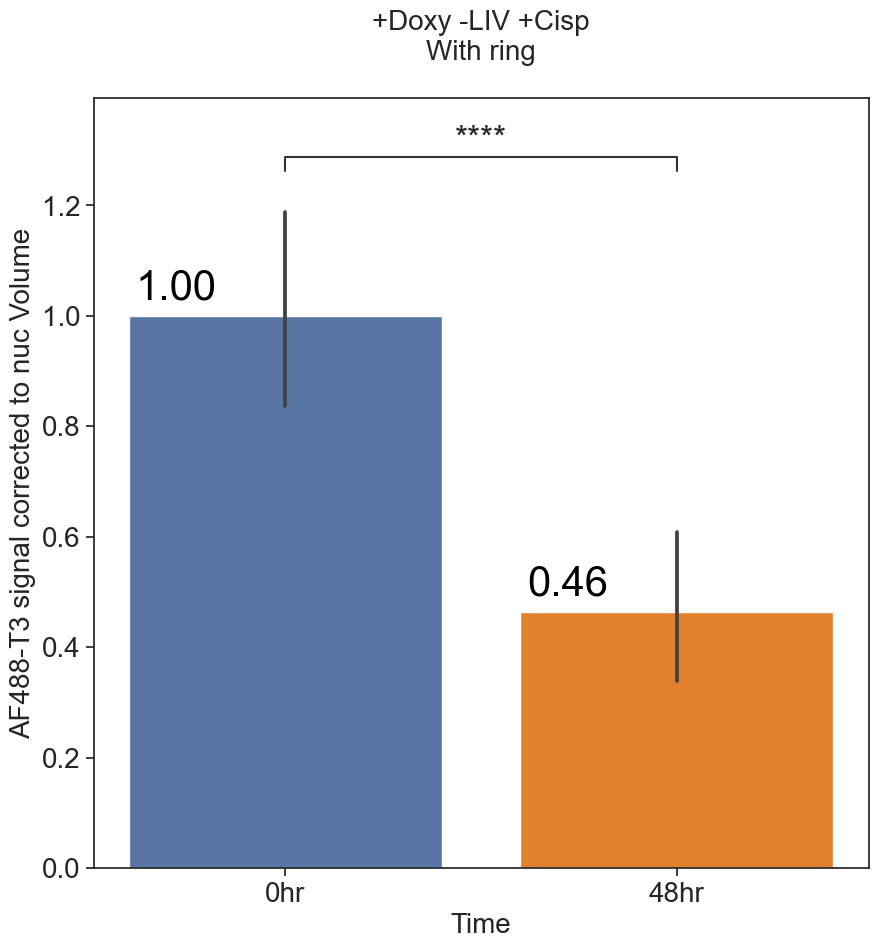

In [838]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/+Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')

## -Doxy -LIV +Cisp 48hr VS. -Doxy +LIV +Cisp 48hr

In [839]:
# Filter DataFrame to only include '+Doxy +Crisp -LIV' group with rings
minus_doxy_plus_cisp_48hr_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()
minus_doxy_plus_cisp_48hr = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr')].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '-LIV' group
average_plus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()

minus_doxy_plus_cisp_48hr_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_plus_liv


print(f"Total -Doxy +Cisp 48hr: {len(minus_doxy_plus_cisp_48hr)}")
print(f"No ring -Doxy -LIV +Cisp: {len(minus_doxy_plus_cisp_48hr_no_ring_df)} = "
      f"-LIV: {len(minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '-LIV'])} + "
      f"+LIV: {len(minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV'])}")

Total -Doxy +Cisp 48hr: 192
No ring -Doxy -LIV +Cisp: 186 = -LIV: 77 + +LIV: 109


In [840]:
plus_doxy_plus_cisp_minus_liv_with_ring_df

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",152.416815,0.452395
927,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",216.712250,0.655934
929,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",319.319316,3.177965
933,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",276.846173,0.620024
935,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",449.871078,1.518459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",251.856204,0.837367
1147,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",102.004251,1.075492
1149,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",315.507131,1.932683
1151,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",100.920925,0.178776


In [841]:
# Extract data for '-LIV' and '+LIV' groups
group_minus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '-LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']
group_plus_liv = minus_doxy_plus_cisp_48hr_no_ring_df[minus_doxy_plus_cisp_48hr_no_ring_df['LIV'] == '+LIV']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D']

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(group_minus_liv, group_plus_liv)

# Print the p-value
print('p-value:', p)

p-value: 1.240522233979485e-12


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

+LIV vs. -LIV: Mann-Whitney-Wilcoxon test two-sided, P_val:1.241e-12 U_stat=6.765e+03


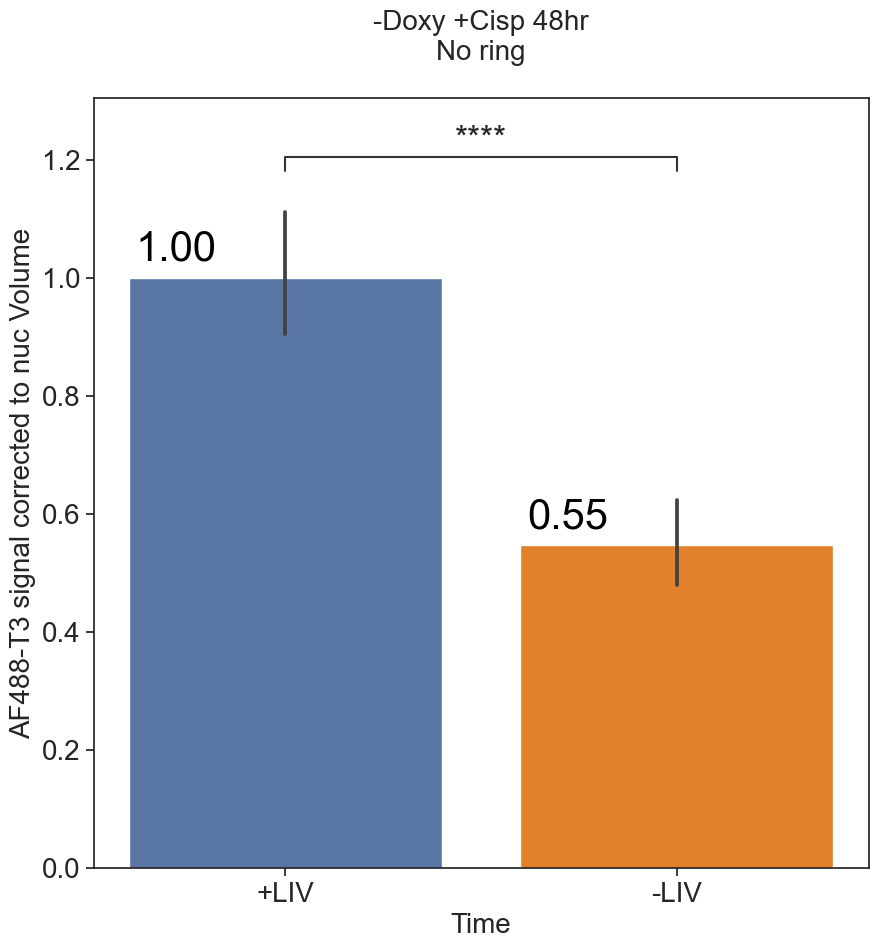

In [842]:
fig_args = {'x': 'LIV',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_48hr_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('-LIV','+LIV')]
sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +Cisp 48hr\nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488-T3 signal corrected to nuc Volume', fontsize=20)

plt.savefig('figures/-Doxy +Cisp 48hr.png', dpi=300, bbox_inches='tight')


In [843]:
plus_doxy_minus_liv_plus_cisp_0hr = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['LIV'] == '-LIV') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '0hr')]

In [844]:
plus_doxy_minus_liv_plus_cisp_0hr

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
925,+doxy,-LIV,+Cisp,0hr,706.750199,19.901837,18.966281,4.60,313.744718,True,1.072088,562.943175,"+doxy, -LIV, +Cisp, 0hr",152.416815,107720.614655
927,+doxy,-LIV,+Cisp,0hr,720.705554,18.030724,21.517798,4.60,364.117814,True,1.014355,627.238609,"+doxy, -LIV, +Cisp, 0hr",216.712250,156185.722205
929,+doxy,-LIV,+Cisp,0hr,2369.763286,29.002250,32.659425,5.52,394.498974,True,1.265901,729.845675,"+doxy, -LIV, +Cisp, 0hr",319.319316,756711.190939
931,+doxy,-LIV,+Cisp,0hr,547.867456,21.602849,17.605471,3.68,401.065567,False,0.967110,723.991453,"+doxy, -LIV, +Cisp, 0hr",313.465094,171737.323410
933,+doxy,-LIV,+Cisp,0hr,533.274893,17.180218,18.541028,4.83,427.205290,True,1.177293,687.372533,"+doxy, -LIV, +Cisp, 0hr",276.846173,147635.113490
935,+doxy,-LIV,+Cisp,0hr,803.703977,16.244662,24.494569,5.29,515.762576,True,1.322664,860.397437,"+doxy, -LIV, +Cisp, 0hr",449.871078,361563.174589
937,+doxy,-LIV,+Cisp,0hr,489.735950,16.414763,17.945674,4.37,294.027460,True,1.232099,784.934102,"+doxy, -LIV, +Cisp, 0hr",374.407743,183360.931590
939,+doxy,-LIV,+Cisp,0hr,724.387385,22.453355,26.110530,3.45,165.536767,False,0.980634,567.982072,"+doxy, -LIV, +Cisp, 0hr",157.455713,114058.931897
941,+doxy,-LIV,+Cisp,0hr,609.580137,23.218810,25.345075,3.45,342.726337,False,0.894373,490.407575,"+doxy, -LIV, +Cisp, 0hr",79.881216,48694.002643
943,+doxy,-LIV,+Cisp,0hr,364.888101,13.182841,15.394156,4.14,351.801339,True,1.397888,1116.607177,"+doxy, -LIV, +Cisp, 0hr",706.080818,257640.488560


In [845]:
plus_doxy_minus_liv_plus_cisp_0hr['AF488-T3 av_signal_in_nuc_area_3D_removed_background'].mean()

389.1564132098572

In [846]:
plus_doxy_minus_liv_plus_cisp_48hr = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['LIV'] == '-LIV') & (filtered_df['Treatment'] == '+Cisp') & (filtered_df['Time'] == '48hr')]
plus_doxy_minus_liv_plus_cisp_48hr

,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 av_signal_in_nuc_area_3D_removed_background,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
1013,+doxy,-LIV,+Cisp,48hr,680.973222,17.605471,19.051331,5.06,338.654065,True,1.216764,491.851612,"+doxy, -LIV, +Cisp, 48hr",81.325252,55380.319156
1015,+doxy,-LIV,+Cisp,48hr,906.320255,17.520421,20.837394,5.29,339.777824,True,1.572345,470.908350,"+doxy, -LIV, +Cisp, 48hr",60.381991,54725.421035
1017,+doxy,-LIV,+Cisp,48hr,896.373654,22.538405,23.729113,4.60,413.803354,True,1.377927,369.403769,"+doxy, -LIV, +Cisp, 48hr",-41.122590,-36861.206490
1019,+doxy,-LIV,+Cisp,48hr,674.400662,17.520421,19.986888,4.37,267.667726,False,0.987808,537.944604,"+doxy, -LIV, +Cisp, 48hr",127.418245,85930.948706
1021,+doxy,-LIV,+Cisp,48hr,579.561483,13.012740,23.814164,4.37,291.447683,False,0.934264,525.573973,"+doxy, -LIV, +Cisp, 48hr",115.047614,66677.165910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,+doxy,-LIV,+Cisp,48hr,791.670229,22.963658,24.324468,3.45,343.857543,True,1.241467,662.382563,"+doxy, -LIV, +Cisp, 48hr",251.856204,199387.058331
1147,+doxy,-LIV,+Cisp,48hr,2510.556310,41.929939,37.677409,4.37,380.217787,True,1.220015,512.530610,"+doxy, -LIV, +Cisp, 48hr",102.004251,256087.415831
1149,+doxy,-LIV,+Cisp,48hr,1458.587440,37.847511,24.409518,3.91,408.887078,True,1.263064,726.033490,"+doxy, -LIV, +Cisp, 48hr",315.507131,460194.738704
1151,+doxy,-LIV,+Cisp,48hr,421.801757,21.432748,14.118397,4.37,608.829430,True,1.418483,511.447284,"+doxy, -LIV, +Cisp, 48hr",100.920925,42568.623309


In [847]:
plus_doxy_minus_liv_plus_cisp_48hr['AF488-T3 av_signal_in_nuc_area_3D_removed_background'].mean()


120.5713817320403